In [81]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

### '围网', '拖网', '刺网'各取一例分析

In [61]:
file_20000="../../hy_round2_train_20200225/20000.csv" #拖网
file_20001="../../hy_round2_train_20200225/20001.csv" #围网
file_20002="../../hy_round2_train_20200225/20002.csv" #刺网

In [62]:
df_20000=pd.read_csv(file_20000)
df_20000.columns=['ship','lat','lon','v','d','time','type']
df_20000.head()

,ship,lat,lon,v,d,time,type
0,20000,21.295,115.563,2.32,50,0912 23:59:55,拖网
1,20000,21.289,115.557,3.29,30,0912 23:49:54,拖网
2,20000,21.282,115.551,3.08,40,0912 23:39:26,拖网
3,20000,21.274,115.547,3.51,20,0912 23:29:49,拖网
4,20000,21.267,115.543,3.08,10,0912 23:19:48,拖网


In [63]:
df_20001=pd.read_csv(file_20001)
df_20001.columns=['ship','lat','lon','v','d','time','type']
df_20001.head()

,ship,lat,lon,v,d,time,type
0,20001,25.172,119.131,0.05,0,0930 23:53:42,围网
1,20001,25.172,119.131,0.00,0,0930 23:43:42,围网
2,20001,25.172,119.131,0.05,0,0930 23:33:42,围网
3,20001,25.172,119.131,0.00,0,0930 23:23:42,围网
4,20001,25.172,119.131,0.00,0,0930 23:13:42,围网


In [64]:
df_20002=pd.read_csv(file_20002)
df_20002.columns=['ship','lat','lon','v','d','time','type']
df_20002.head()

,ship,lat,lon,v,d,time,type
0,20002,27.287,120.261,0.00,20,1027 11:51:43,刺网
1,20002,27.287,120.261,0.32,50,1027 11:41:14,刺网
2,20002,27.287,120.261,0.11,0,1027 11:31:15,刺网
3,20002,27.287,120.261,0.11,0,1027 11:21:19,刺网
4,20002,27.287,120.261,0.22,102,1027 11:11:20,刺网


### 根据经纬度转化为平面坐标

[lat,lon -> x,y](https://blog.csdn.net/weixin_43428682/article/details/87889753)
* 经度：longitude 纬度： latitude
* 椭圆的长半轴: a
* 椭圆的短半轴: b

[两类偏心率](https://baike.baidu.com/item/%E6%A4%AD%E7%90%83%E5%81%8F%E5%BF%83%E7%8E%87/4944476?fr=aladdin)
* 椭圆的第一偏心率: $ e=\frac{\sqrt{a^2-b^2}}{a} $  
* 椭圆的第二偏心率: $ e'=\frac{\sqrt{a^2-b^2}}{b} $

In [65]:
a=6378137.0000
b=6356752.3142
B0=0
lon0=0
def k_val_compute():
    e_=np.sqrt(a**2-b**2)/b
    return a**2*np.cos(B0)/(b*np.sqrt((1+(e_*np.cos(B0))**2)))

def X_unit_trans(lon):
    lon_rad=lon*np.pi/180 #角度-> 弧度
    k=k_val_compute()
    return k*(lon_rad-lon0)

def Y_unit_trans(lat):
    lat_rad=lat*np.pi/180 #角度-> 弧度
    k=k_val_compute()
    e=np.sqrt(a**2-b**2)/a
    dot_val=np.tan(np.pi/4+lat_rad/2)*((1-e*np.sin(lat_rad))/(1+e*np.sin(lat_rad)))**(e/2)                        
    return k*np.log(dot_val)

In [67]:
for df in [df_20001,df_20002,df_20000]:
    df['x']=df.lon.apply(X_unit_trans) # lon->x
    df['y']=df.lat.apply(Y_unit_trans) # lat->y

#### 相关性探索

In [90]:
df_20000.corr()

,ship,lat,lon,v,d,x,y
ship,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,NaN,1.000000,0.920760,-0.060709,-0.099331,0.920760,1.000000
lon,NaN,0.920760,1.000000,-0.115258,-0.081694,1.000000,0.920671
v,NaN,-0.060709,-0.115258,1.000000,-0.019940,-0.115258,-0.060652
d,NaN,-0.099331,-0.081694,-0.019940,1.000000,-0.081694,-0.099367
x,NaN,0.920760,1.000000,-0.115258,-0.081694,1.000000,0.920671
y,NaN,1.000000,0.920671,-0.060652,-0.099367,0.920671,1.000000


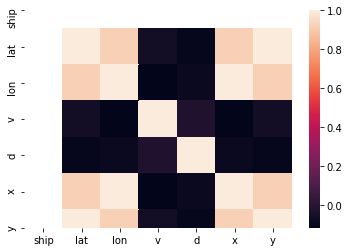

In [91]:
sns.heatmap(df_20000.corr())

In [84]:
df_20001.corr()

,ship,lat,lon,v,d,x,y
ship,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,NaN,1.000000,-0.489733,-0.436177,-0.498323,-0.489733,1.000000
lon,NaN,-0.489733,1.000000,0.494238,0.491504,1.000000,-0.489825
v,NaN,-0.436177,0.494238,1.000000,0.695077,0.494238,-0.436274
d,NaN,-0.498323,0.491504,0.695077,1.000000,0.491504,-0.498376
x,NaN,-0.489733,1.000000,0.494238,0.491504,1.000000,-0.489825
y,NaN,1.000000,-0.489825,-0.436274,-0.498376,-0.489825,1.000000


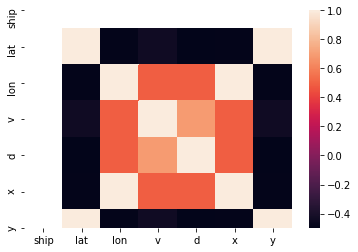

In [93]:
sns.heatmap(df_20001.corr())

In [85]:
df_20002.corr()

,ship,lat,lon,v,d,x,y
ship,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,NaN,1.000000,-0.614669,-0.080127,0.201016,-0.614669,1.000000
lon,NaN,-0.614669,1.000000,0.034709,-0.291025,1.000000,-0.614669
v,NaN,-0.080127,0.034709,1.000000,0.180472,0.034709,-0.080127
d,NaN,0.201016,-0.291025,0.180472,1.000000,-0.291025,0.201016
x,NaN,-0.614669,1.000000,0.034709,-0.291025,1.000000,-0.614669
y,NaN,1.000000,-0.614669,-0.080127,0.201016,-0.614669,1.000000


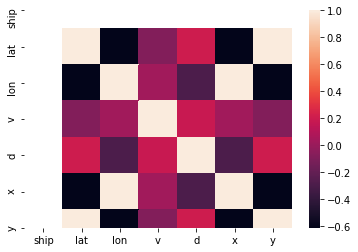

In [94]:
sns.heatmap(df_20002.corr())

### v ,d 可视化

In [95]:
def v_d_show(df_file):
    fig,ax=plt.subplots(nrows=1,ncols=2)
    ax[0].hist(df_file.v)
    ax[0].set_title('v',fontdict={'size':16,'family':'Times-Roman'})
    ax[1].hist(df_file.d)
    ax[1].set_title('d',fontdict={'size':16,'family':'Times-Roman'})

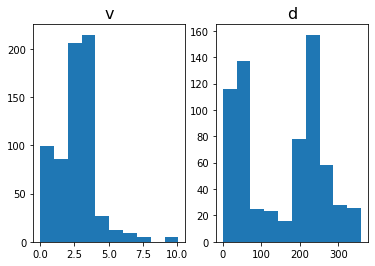

In [96]:
v_d_show(df_20000)

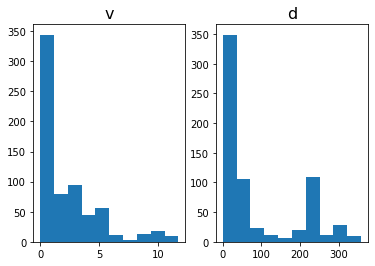

In [97]:
v_d_show(df_20001)

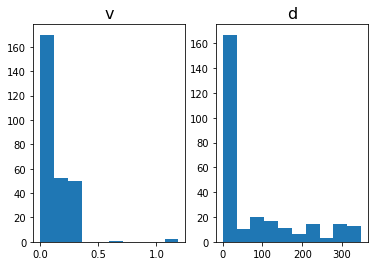

In [98]:
v_d_show(df_20002)

### x-y,lon-lat 可视化

In [99]:
def show_path(file):
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6.4,4.8))
    ax[0].plot(file['x'], file['y'])
    ax[0].set_title('xy trace',fontdict={'size':16,'family':'Times-Roman'})
    ax[1].plot(file['lon'], file['lat'])
    ax[1].set_title('lon-lat trace',fontdict={'size':16,'family':'Times-Roman'})

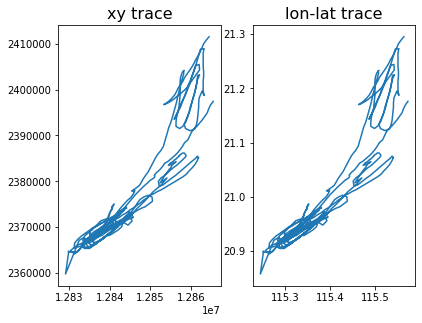

In [100]:
show_path(df_20000)

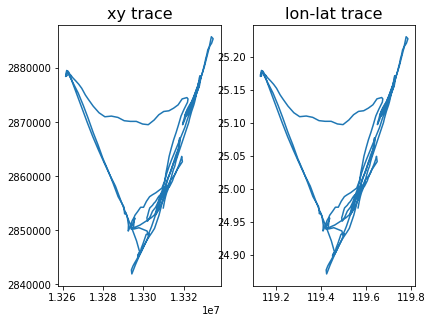

In [101]:
show_path(df_20001)

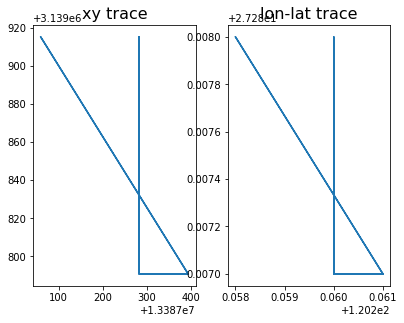

In [102]:
show_path(df_20002)

### 时间转化

In [126]:
for df in [df_20000,df_20001,df_20002]:
    df.time=pd.to_datetime(df.time,format='%m%d %H:%M:%S')
    df['day']=df.time.dt.day
    df['hour']=df.time.dt.hour
    df['second']=df.time.dt.second
    df['minute']=df.time.dt.minute

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4AAB586D8>,
      dtype=object)

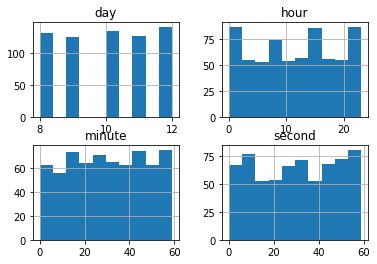

In [132]:
df_20000[['day','hour','second','minute',]].hist()

In [162]:
df_20000['time'].dt.date

0      1900-09-12
1      1900-09-12
2      1900-09-12
3      1900-09-12
4      1900-09-12
5      1900-09-12
6      1900-09-12
7      1900-09-12
8      1900-09-12
9      1900-09-12
10     1900-09-12
11     1900-09-12
12     1900-09-12
13     1900-09-12
14     1900-09-12
15     1900-09-12
16     1900-09-12
17     1900-09-12
18     1900-09-12
19     1900-09-12
20     1900-09-12
21     1900-09-12
22     1900-09-12
23     1900-09-12
24     1900-09-12
25     1900-09-12
26     1900-09-12
27     1900-09-12
28     1900-09-12
29     1900-09-12
          ...    
634    1900-09-08
635    1900-09-08
636    1900-09-08
637    1900-09-08
638    1900-09-08
639    1900-09-08
640    1900-09-08
641    1900-09-08
642    1900-09-08
643    1900-09-08
644    1900-09-08
645    1900-09-08
646    1900-09-08
647    1900-09-08
648    1900-09-08
649    1900-09-08
650    1900-09-08
651    1900-09-08
652    1900-09-08
653    1900-09-08
654    1900-09-08
655    1900-09-08
656    1900-09-08
657    1900-09-08
658    190